In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

In [3]:
sample_df = pd.read_csv("raw_data/sample_submission_v2.csv")

In [6]:
sample_df = sample_df.head(10)

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0
5,nu1jZ/flvSaXRg0U9Es+xmo2KlAXq/q+mhcWFStwm9w=,0
6,biDTtgK83fEWXJDaxzD1eh22dion/h3odeIbS7qJMmY=,0
7,k/8uwi/iM9LZmRAIWXLqpZY6ENomXAscwsQsh6PxcTw=,0
8,18rQ/746SjA6nBx325UsyhfsDhu4tK01FXFxHWZjw20=,0
9,2V13OCoWx6vqKr/ZzNmKFrmnC2FtR4SWMz5C5Hi02PY=,0


In [7]:
train_df= pd.read_csv("raw_data/churn_df_underbalanced.csv")

In [4]:
train_df.head(2)


,Unnamed: 0,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,remaining_plan_duration,...,expire_year,expire_month_sin,expire_month_cos,expire_day_sin,expire_day_cos,registration_year,registration_month_sin,registration_month_cos,registration_day_sin,registration_day_cos
0,821709,k4WiyQIt5gRLVWRbZc5PF4z9FBCiVZZDYhdnO53FQ00=,0,41.0,30.0,149.0,149.0,1.0,0.0,31,...,2017,0.866025,-0.5,-0.937752,0.347305,2013,0.5,0.866025,0.998717,-0.050649
1,555198,XAYGsx5L1n1DeDysZy4NzvNXBDsbCi3PR84DENjrFK0=,0,41.0,30.0,99.0,99.0,1.0,0.0,31,...,2017,0.866025,-0.5,-0.998717,-0.050649,2016,-0.5,-0.866025,-0.998717,-0.050649


In [5]:
# data_df = train_df.sample(50000, random_state=42)

In [6]:
data_df = train_df

In [7]:
data_df = data_df.drop(['Unnamed: 0', 'msno'], axis=1)

In [8]:
data_df

,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,remaining_plan_duration,is_discount,num_25,...,expire_year,expire_month_sin,expire_month_cos,expire_day_sin,expire_day_cos,registration_year,registration_month_sin,registration_month_cos,registration_day_sin,registration_day_cos
0,0,41.0,30.0,149.0,149.0,1.0,0.0,31,0,1.0,...,2017,8.660254e-01,-5.000000e-01,-0.937752,0.347305,2013,5.000000e-01,0.866025,0.998717,-0.050649
1,0,41.0,30.0,99.0,99.0,1.0,0.0,31,0,1.0,...,2017,8.660254e-01,-5.000000e-01,-0.998717,-0.050649,2016,-5.000000e-01,-0.866025,-0.998717,-0.050649
2,0,41.0,30.0,99.0,99.0,1.0,0.0,31,0,2.0,...,2017,8.660254e-01,-5.000000e-01,0.651372,-0.758758,2015,-8.660254e-01,-0.500000,0.651372,-0.758758
3,0,29.0,30.0,180.0,180.0,0.0,0.0,30,0,8.0,...,2017,8.660254e-01,-5.000000e-01,0.988468,0.151428,2015,5.000000e-01,-0.866025,0.998717,-0.050649
4,0,40.0,30.0,149.0,149.0,1.0,0.0,37,0,17.0,...,2017,8.660254e-01,-5.000000e-01,-0.201299,0.979530,2009,1.224647e-16,-1.000000,0.201299,0.979530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55989,1,39.0,30.0,149.0,149.0,1.0,1.0,35,0,2.0,...,2017,8.660254e-01,-5.000000e-01,0.485302,-0.874347,2013,-5.000000e-01,0.866025,-0.897805,-0.440394
55990,1,41.0,30.0,99.0,99.0,1.0,0.0,61,0,20.0,...,2017,5.000000e-01,-8.660254e-01,-0.897805,-0.440394,2013,-2.449294e-16,1.000000,0.937752,0.347305
55991,1,41.0,30.0,149.0,149.0,1.0,1.0,0,0,9.0,...,2017,1.000000e+00,6.123234e-17,-0.988468,0.151428,2013,-2.449294e-16,1.000000,0.988468,0.151428
55992,1,15.0,90.0,300.0,300.0,0.0,0.0,89,0,224.0,...,2017,1.224647e-16,-1.000000e+00,0.571268,0.820763,2013,-2.449294e-16,1.000000,0.485302,-0.874347


In [9]:
# data_df.isnull().sum()

In [10]:
data_df.is_churn.value_counts()

is_churn
0    27997
1    27997
Name: count, dtype: int64

In [11]:
scale_features = ['payment_method_id',
                  'payment_plan_days',
                  'plan_list_price',
                  'actual_amount_paid',
                  'remaining_plan_duration',
                  'num_25',
                  'num_50',
                  'num_75',
                  'num_985',
                  'num_100',
                  'num_unq',
                  'total_secs',
                  'city',
                  'registered_via',
                  'usage_from_ltd',
                  'registration_year',
                  'expire_year',
                  'last_transaction_year'
                 ]

In [12]:
# # Build the pipeline with the different steps
# num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),
#                              StandardScaler()
#                             )

# preprocessor = ColumnTransformer([
#     ('num_transformer', num_pipeline, make_column_selector(dtype_include=["int64", "float64"]))],
#     remainder='passthrough'
# )


In [13]:
# Build the pipeline with the different steps
num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),
                             StandardScaler()
                            )

preprocessor = ColumnTransformer([
    ('num_transformer', num_pipeline, scale_features)],
    remainder='passthrough'
)


In [14]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['payment_method_id', 'payment_plan_days',
                                  'plan_list_price', 'actual_amount_paid',
                                  'remaining_plan_duration', 'num_25', 'num_50',
                                  'num_75', 'num_985', 'num_100', 'num_unq',
                                  'total_secs', 'city', 'registered_via',
                                  'usage_from_ltd', 'registration_year',
                                  'expire_year', 'last_transaction_year'])])

In [15]:
X = data_df.drop(['is_churn','bd'], axis=1)
y= data_df['is_churn']

In [16]:
preprocessor.fit(X)
            

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['payment_method_id', 'payment_plan_days',
                                  'plan_list_price', 'actual_amount_paid',
                                  'remaining_plan_duration', 'num_25', 'num_50',
                                  'num_75', 'num_985', 'num_100', 'num_unq',
                                  'total_secs', 'city', 'registered_via',
                                  'usage_from_ltd', 'registration_year',
                                  'expire_year', 'last_transaction_year'])])

In [17]:
X_train_transformed = preprocessor.fit_transform(X)

In [18]:
X_train_transformed = pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out()
)

In [19]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55994 entries, 0 to 55993
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   num_transformer__payment_method_id        55994 non-null  float64
 1   num_transformer__payment_plan_days        55994 non-null  float64
 2   num_transformer__plan_list_price          55994 non-null  float64
 3   num_transformer__actual_amount_paid       55994 non-null  float64
 4   num_transformer__remaining_plan_duration  55994 non-null  float64
 5   num_transformer__num_25                   55994 non-null  float64
 6   num_transformer__num_50                   55994 non-null  float64
 7   num_transformer__num_75                   55994 non-null  float64
 8   num_transformer__num_985                  55994 non-null  float64
 9   num_transformer__num_100                  55994 non-null  float64
 10  num_transformer__num_unq          

In [20]:
X_train_transformed.columns

Index(['num_transformer__payment_method_id',
       'num_transformer__payment_plan_days',
       'num_transformer__plan_list_price',
       'num_transformer__actual_amount_paid',
       'num_transformer__remaining_plan_duration', 'num_transformer__num_25',
       'num_transformer__num_50', 'num_transformer__num_75',
       'num_transformer__num_985', 'num_transformer__num_100',
       'num_transformer__num_unq', 'num_transformer__total_secs',
       'num_transformer__city', 'num_transformer__registered_via',
       'num_transformer__usage_from_ltd', 'num_transformer__registration_year',
       'num_transformer__expire_year',
       'num_transformer__last_transaction_year', 'remainder__is_auto_renew',
       'remainder__is_cancel', 'remainder__is_discount',
       'remainder__period_0_churn', 'remainder__period_-1_churn',
       'remainder__period_-2_churn', 'remainder__period_-3_churn',
       'remainder__period_-4_churn', 'remainder__period_-5_churn',
       'remainder__discount_perce

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X_train_transformed, y, test_size=0.2, random_state=42)

In [22]:
# print("Before SMOTE, counts of label '1':", sum(y_train==1))
# print("Before SMOTE, counts of label '0':", sum(y_train==0))

# # Apply SMOTE
# sm = SMOTE(random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train_transformed, y)

# # Check class distribution in resampled dataset
# print("After SMOTE, counts of label '1':", sum(y_train_res==1))
# print("After SMOTE, counts of label '0':", sum(y_train_res==0))

In [23]:
# X_train_res["is_churn"] = y_train_res
# X_train_res

In [24]:
# data = X_train_res.sample(frac=1, random_state=42)

In [25]:
# data

In [26]:
# X_train_r = data.drop(columns='is_churn')
# y_train_r = data.is_churn

In [27]:
rf = LogisticRegression( max_iter=1000, random_state=42)

In [28]:
scores = cross_val_score(rf, X_train_transformed, y, cv=5)
scores.mean()

0.8954531300563108

In [30]:
X_train_transformed

,num_transformer__payment_method_id,num_transformer__payment_plan_days,num_transformer__plan_list_price,num_transformer__actual_amount_paid,num_transformer__remaining_plan_duration,num_transformer__num_25,num_transformer__num_50,num_transformer__num_75,num_transformer__num_985,num_transformer__num_100,...,remainder__last_transaction_day_sin,remainder__last_transaction_day_cos,remainder__expire_month_sin,remainder__expire_month_cos,remainder__expire_day_sin,remainder__expire_day_cos,remainder__registration_month_sin,remainder__registration_month_cos,remainder__registration_day_sin,remainder__registration_day_cos
0,0.652666,-0.279389,-0.233158,-0.228176,-0.343215,-0.289482,-0.512507,-0.592194,-0.362069,-0.564720,...,-0.937752,0.347305,8.660254e-01,-5.000000e-01,-0.937752,0.347305,5.000000e-01,0.866025,0.998717,-0.050649
1,0.652666,-0.279389,-0.412546,-0.407169,-0.343215,-0.289482,-0.512507,-0.592194,-0.398173,-0.580850,...,-0.998717,-0.050649,8.660254e-01,-5.000000e-01,-0.998717,-0.050649,-5.000000e-01,-0.866025,-0.998717,-0.050649
2,0.652666,-0.279389,-0.412546,-0.407169,-0.343215,-0.284984,-0.512507,-0.471025,-0.325965,-0.336877,...,0.651372,-0.758758,8.660254e-01,-5.000000e-01,0.651372,-0.758758,-8.660254e-01,-0.500000,0.651372,-0.758758
3,-1.814823,-0.279389,-0.121938,-0.117200,-0.355387,-0.257994,-0.372288,-0.410440,-0.181548,-0.457856,...,0.998717,-0.050649,8.660254e-01,-5.000000e-01,0.988468,0.151428,5.000000e-01,-0.866025,0.998717,-0.050649
4,0.447042,-0.279389,-0.233158,-0.228176,-0.270181,-0.217508,-0.407343,-0.228685,-0.289861,-0.560687,...,-0.988468,0.151428,8.660254e-01,-5.000000e-01,-0.201299,0.979530,1.224647e-16,-1.000000,0.201299,0.979530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55989,0.241417,-0.279389,-0.233158,-0.228176,-0.294525,-0.284984,-0.547561,-0.531609,-0.362069,-0.556655,...,0.968077,-0.250653,8.660254e-01,-5.000000e-01,0.485302,-0.874347,-5.000000e-01,0.866025,-0.897805,-0.440394
55990,0.652666,-0.279389,-0.412546,-0.407169,0.021954,-0.204013,-0.477452,-0.531609,-0.362069,-0.476002,...,-0.897805,-0.440394,5.000000e-01,-8.660254e-01,-0.897805,-0.440394,-2.449294e-16,1.000000,0.937752,0.347305
55991,0.652666,-0.279389,-0.233158,-0.228176,-0.720555,-0.253495,-0.547561,-0.592194,-0.398173,-0.427611,...,-0.988468,0.151428,1.000000e+00,6.123234e-17,-0.988468,0.151428,-2.449294e-16,1.000000,0.988468,0.151428
55992,-4.693560,0.601760,0.308594,0.312384,0.362777,0.713657,1.415495,1.952372,1.515350,2.052451,...,0.937752,0.347305,1.224647e-16,-1.000000e+00,0.571268,0.820763,-2.449294e-16,1.000000,0.485302,-0.874347


In [31]:
# rf.fit(X_train_res, y_train_res)
# y_pred = rf.predict(X_test)
# accuracy_score(y_test, y_pred)

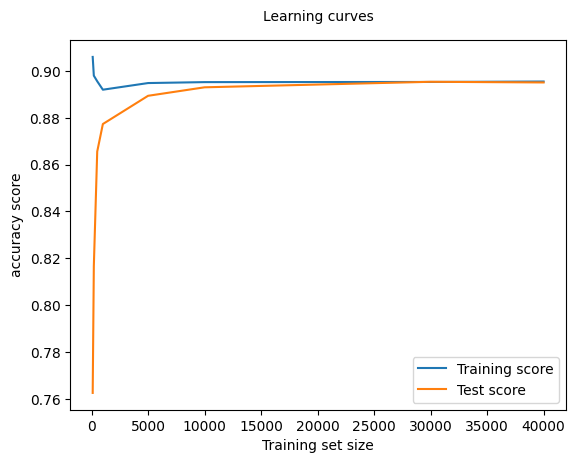

In [32]:
from sklearn.model_selection import learning_curve

train_sizes = [100, 200, 500, 1000, 5000, 10000, 30000, 40000]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=LogisticRegression(max_iter=2000, random_state=42), 
    X=X_train_transformed, 
    y=y, 
    train_sizes=train_sizes,
    shuffle=True,
    cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize=10)
plt.xlabel('Training set size', fontsize=10)
plt.title('Learning curves', fontsize=10, y=1.03)
# plt.ylim(0.8,1)
plt.legend()
plt.show();

In [35]:
# Fit the classifier to your data
# rf_classifier = Randomforest()
# rf_classifier.fit(X_train_transformed, y)

# # Get feature importances
# feature_importances = rf_classifier.feature_importances_

# # Get the indices of features sorted by importance in descending order
# sorted_indices = np.argsort(feature_importances)[::-1]

# # Print feature importance scores and corresponding feature names
# names = []
# for i in range(len(sorted_indices)):
#     index = sorted_indices[i]
#     importance_score = feature_importances[index]
#     feature_name = X.columns[index]  # Replace with your feature names if you have them
#     names.append(feature_name)
#     print(f"Feature {i + 1}: {feature_name} - Importance: {importance_score:.4f}")
# names

In [21]:
# hyperparameter tuning GridSeach CV

In [33]:
# # Number of trees in random forest
# n_estimators = [20,60,100,120]

# # Number of features to consider at every split
# max_features = [0.2,0.6,1.0]

# # Maximum number of levels in tree
# max_depth = [2,8,None]

# # Number of samples
# max_samples = [0.5,0.75,1.0]

In [34]:
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#               'max_samples':max_samples
#              }
# print(param_grid)

In [35]:
### Gridsearch 

In [36]:
# rf = LogisticRegression(max_iter=1000)
# from sklearn.model_selection import GridSearchCV

# rf_grid = GridSearchCV(estimator = rf, 
#                        param_grid = param_grid, 
#                        cv = 5, 
#                        verbose=2, 
#                        n_jobs = -1)

In [37]:
# rf_grid.fit(X_train_transformed,y)

In [38]:
param_grid = {
    'penalty': ['l1', 'l2'],        # Regularization type (L1 or L2)
    'C': [3.5, 4, 4.82, 6],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],   # Optimization algorithm
    'max_iter' : [5, 11, 15, 20, 50] 
}

# Create a logistic regression model
logistic_regression = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    logistic_regression,  # Estimator
    param_grid,            # Hyperparameter grid
    scoring='precision',    # Scoring metric (you can change this)
    cv=5,                  # Cross-validation folds
    verbose=1,             # Set to 1 for progress info
    n_jobs=-1              # Use all available CPU cores
)

In [40]:
grid_search.fit(X_train_transformed, y)



Fitting 5 folds for each of 80 candidates, totalling 400 fits


/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: Conve

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [3.5, 4, 4.82, 6],
                         'max_iter': [5, 11, 15, 20, 50],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='precision', verbose=1)

In [41]:
# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score (Accuracy):", grid_search.best_score_)

Best Hyperparameters: {'C': 4, 'max_iter': 5, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score (Accuracy): 0.9218908769442882


In [43]:
#feature importance top 15
model= LogisticRegression(random_state=42)
model.fit(X_train_transformed, y)
coefficients = model.coef_[0]
top_15_features = np.argsort(np.abs(coefficients))[-15:][::-1]
feature_names = X_train_transformed.columns
top_15_features = feature_names[top_15_features].tolist()
top_15_features

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['num_transformer__remaining_plan_duration',
 'remainder__is_cancel',
 'remainder__expire_month_cos',
 'remainder__discount_percentage',
 'remainder__last_transaction_month_sin',
 'num_transformer__expire_year',
 'remainder__expire_month_sin',
 'remainder__last_transaction_month_cos',
 'remainder__is_auto_renew',
 'remainder__is_discount',
 'num_transformer__plan_list_price',
 'remainder__period_-5_churn',
 'num_transformer__payment_plan_days',
 'remainder__period_-3_churn',
 'remainder__period_0_churn']

In [40]:
X_train_res =  X_train_res[['num_transformer__actual_amount_paid',
       'num_transformer__remaining_plan_duration', 'num_transformer__num_25',
       'num_transformer__num_100', 'remainder__last_transaction_day_sin',
       'remainder__last_transaction_day_cos', 'remainder__expire_day_sin',
       'remainder__expire_day_cos', 'remainder__registration_day_sin',
       'remainder__registration_day_cos']]

In [43]:
X_train_res.shape


(3504, 10)

In [28]:
# pred = bayes_cv.predict(X_test)

In [29]:
# from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
# from sklearn.metrics import confusion_matrix,classification_report,precision_score, recall_score, f1_score, accuracy_score

In [30]:
# print("Best Hyperparameters:", bayes_cv.best_params_)
# print("Best Score (Accuracy):", bayes_cv.best_score_)

In [54]:
# from sklearn.metrics import roc_auc_score
# from bayes_opt import BayesianOptimization, UtilityFunction
# import warnings
# warnings.filterwarnings("ignore")
# from sklearn.svm import SVC

# def black_box_function(C):
#     # C: SVC hyper parameter to optimize for.
#     model = SVC(C=C)
#     model.fit(X_train_res, y_train_res)
#     y_score = model.decision_function(X_test)
#     f = roc_auc_score(y_test, y_score)
#     return f
# # Set range of C to optimize for.
# # bayes_opt requires this to be a dictionary.
# pbounds = {"C": [0.1, 10]}
# # Create a BayesianOptimization optimizer,
# # and optimize the given black_box_function.
# optimizer = BayesianOptimization(f = black_box_function,
#                                  pbounds=pbounds,
#                                   verbose = 2,
#                                  random_state = 42)
# optimizer.maximize(init_points = 5, n_iter = 10)
# print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

In [19]:
#X_train_transformed.replace([np.inf, -np.inf], np.nan, inplace=True)

In [20]:
#X_train_transformed.isnull().sum()

In [21]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score

def get_estimators():
    return {
        'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter=1000),
        'KNN': KNeighborsClassifier(),
        'RandomForest': RandomForestClassifier(n_estimators=100),
        'XGB': XGBClassifier(), 
        'Vaoting Classifier': VotingClassifier(estimators=[('gbr', GradientBoostingClassifier()), ('xgb', XGBClassifier())]),
        'AdaBoostClassifier': AdaBoostClassifier(base_estimator=GradientBoostingClassifier(),n_estimators=100)
    }



In [22]:
# cross-validation for each model and store results in a dict
results = []
estimators = get_estimators()
for name, estimator in estimators.items():
    scores = cross_val_score(estimator, X_train_res,y_train_res, cv=5)
    results.append({
        'Model': name,
        'Mean Accuracy': np.mean(scores),
    })

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
  File "/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sk

In [23]:
results

[{'Model': 'LogisticRegression', 'Mean Accuracy': 0.8430409618911758},
 {'Model': 'KNN', 'Mean Accuracy': nan},
 {'Model': 'RandomForest', 'Mean Accuracy': 0.9743207662522927},
 {'Model': 'XGB', 'Mean Accuracy': 0.9688974933768086},
 {'Model': 'Vaoting Classifier', 'Mean Accuracy': 0.9646174852251885},
 {'Model': 'AdaBoostClassifier', 'Mean Accuracy': 0.9703248420623598}]

In [27]:
print(X_train_res.shape)
print(y_train_res.shape)
print(X_test.shape)
print(y_test.shape)

(3504, 39)
(3504,)
(501, 39)
(501,)


In [40]:
type(X_train)

pandas.core.frame.DataFrame

In [29]:
result=[]
for name, estimator in estimators.items():
    estimator.fit(X_train_res, y_train_res)
    if name == 'KNN':
        y_pred = estimator.predict(X_test.values)
    else:
        y_pred = estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    result.append(f"Accuracy of {name} is: {accuracy:.2f}")
result

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

['Accuracy of LogisticRegression is: 0.87',
 'Accuracy of KNN is: 0.80',
 'Accuracy of RandomForest is: 0.97',
 'Accuracy of XGB is: 0.96',
 'Accuracy of Vaoting Classifier is: 0.96',
 'Accuracy of AdaBoostClassifier is: 0.96']

In [63]:
preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, 
)

In [64]:
preproc_selector.fit(X_train_res, y_train_res)

SelectPercentile(percentile=25,
                 score_func=<function mutual_info_regression at 0x7f56f0195d80>)

In [65]:
selected_features_mask = preproc_selector.get_support()


In [66]:
X_train_res.select_dtypes(include='float').columns[selected_features_mask]

Index(['num_transformer__actual_amount_paid',
       'num_transformer__remaining_plan_duration', 'num_transformer__num_25',
       'num_transformer__num_100', 'remainder__last_transaction_day_sin',
       'remainder__last_transaction_day_cos', 'remainder__expire_day_sin',
       'remainder__expire_day_cos', 'remainder__registration_day_sin',
       'remainder__registration_day_cos'],
      dtype='object')

In [44]:
X_train_res

,num_transformer__payment_method_id,num_transformer__payment_plan_days,num_transformer__plan_list_price,num_transformer__actual_amount_paid,num_transformer__remaining_plan_duration,num_transformer__num_25,num_transformer__num_50,num_transformer__num_75,num_transformer__num_985,num_transformer__num_100,...,remainder__expire_year,remainder__expire_month_sin,remainder__expire_month_cos,remainder__expire_day_sin,remainder__expire_day_cos,remainder__registration_year,remainder__registration_month_sin,remainder__registration_month_cos,remainder__registration_day_sin,remainder__registration_day_cos
0,0.149706,-0.182971,-0.122138,-0.119878,-0.207453,-0.408958,-0.202546,-0.062272,-0.113284,0.162854,...,2017.000000,0.866025,-5.000000e-01,0.848644,0.528964,2010.000000,-8.660254e-01,-0.500000,-0.937752,0.347305
1,-0.313105,-0.182971,-0.122138,-0.119878,-0.261264,-0.550660,-0.456719,-0.555129,-0.113284,-0.682244,...,2017.000000,0.866025,-5.000000e-01,0.937752,0.347305,2012.000000,-2.449294e-16,1.000000,-0.790776,-0.612106
2,0.381112,-0.182971,-0.122138,-0.119878,-0.207453,3.416991,-0.202546,0.923442,-0.113284,-0.092641,...,2017.000000,0.866025,-5.000000e-01,0.937752,0.347305,2011.000000,8.660254e-01,-0.500000,0.651372,-0.758758
3,-1.007322,-0.182971,-0.122138,-0.119878,-0.261264,-0.338107,-0.202546,-0.555129,-0.538058,-0.721550,...,2017.000000,0.866025,-5.000000e-01,-0.201299,0.979530,2012.000000,8.660254e-01,0.500000,-0.485302,-0.874347
4,0.149706,-0.182971,-0.122138,-0.119878,-0.171579,-0.408958,-0.202546,-0.555129,-0.538058,-0.682244,...,2017.000000,0.866025,-5.000000e-01,0.968077,-0.250653,2006.000000,-8.660254e-01,0.500000,-0.299363,-0.954139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,-1.394422,-0.467832,-0.482884,-0.480288,1.478497,0.718208,-0.096249,-0.295263,0.512295,1.446048,...,2017.472735,0.929360,-2.636326e-01,-0.285464,-0.338901,2015.418204,4.094004e-01,0.763633,0.601152,-0.338901
3500,0.402766,-0.182971,-0.122138,-0.119878,0.021172,0.091548,-0.432933,-0.555129,-0.498308,-0.006563,...,2017.000000,0.831773,-5.342523e-01,0.910953,0.243801,2010.093579,8.660254e-01,-0.406421,-0.934014,0.273593
3501,0.612517,-0.182971,-0.138924,-0.136649,0.216530,-0.077926,-0.160892,1.004212,-0.538058,-0.323354,...,2017.000000,0.336119,-8.660254e-01,-0.759693,0.632975,2010.836119,7.541785e-01,0.141925,0.672797,0.183528
3502,-3.998917,6.674005,5.260570,5.257813,2.706045,0.729801,0.432955,0.606624,0.948764,-0.296184,...,2018.000000,0.866025,5.000000e-01,-0.670342,0.716538,2014.000000,-1.785905e-01,-0.333491,-0.312867,0.069014


In [46]:
y_train

2123    0
2280    0
1085    0
1868    0
1412    0
       ..
1638    0
1095    0
1130    0
1294    0
860     0
Name: is_churn, Length: 2000, dtype: int64

In [48]:
new_data = pd.merge(X_train_res,y_train_res, left_index=True, right_index=True)

In [51]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   num_transformer__payment_method_id        3504 non-null   float64
 1   num_transformer__payment_plan_days        3504 non-null   float64
 2   num_transformer__plan_list_price          3504 non-null   float64
 3   num_transformer__actual_amount_paid       3504 non-null   float64
 4   num_transformer__remaining_plan_duration  3504 non-null   float64
 5   num_transformer__num_25                   3504 non-null   float64
 6   num_transformer__num_50                   3504 non-null   float64
 7   num_transformer__num_75                   3504 non-null   float64
 8   num_transformer__num_985                  3504 non-null   float64
 9   num_transformer__num_100                  3504 non-null   float64
 10  num_transformer__num_unq            

In [68]:
# nn= new_data[['is_churn','num_transformer__actual_amount_paid',
#        'num_transformer__remaining_plan_duration', 'num_transformer__num_25',
#        'num_transformer__num_100', 'remainder__last_transaction_day_sin',
#        'remainder__last_transaction_day_cos', 'remainder__expire_day_sin',
#        'remainder__expire_day_cos', 'remainder__registration_day_sin',
#        'remainder__registration_day_cos']]
# corr_matrix = nn.corr()
# plt.figure(figsize=(8, 6))
# heatmap = sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black')
# plt.title('Correlation Heatmap')
# plt.show()

In [ ]:
X_is_cancelled_removed = X_train_transformed.drop(columns=["remainder__is_cancel"]